In [1]:
import pandas as pd
import numpy as np
import os
from psychopy import visual, tools
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

# D-prime calculation

In [ ]:
f_name = '0_0_attn_0_Logs20210216224329/0_0_attn_0_events.tsv'
df = pd.read_table(f_name, keep_default_na=True)

# change NaNs to 0 
df['duration'] = df['duration'].fillna(0)
df['nr_frames'] = df['nr_frames'].fillna(0)

# add columns for end times
df['end'] = df.onset + df.duration
df['end_abs'] = df.onset_abs + df.durationZ = norm.ppf

In [3]:
def d_prime(hits,misses,fas,crs):
    """
    calculate d' from hits(tp), misses(fn), false
    alarms (fp), and correct rejections (tn)
    
    returns: d_prime
    """
    
    half_hit = 0.5 / (hits+misses)
    half_fa = 0.5 / (fas+crs)
    
    hit_rate = hits/(hits+misses)
    fa_rate = fas/(fas + crs)
    
    # avoid d' infinity
    if hit_rate == 1:
        hit_rate = 1 -half_hit
    elif hit_rate == 0:
        hit_rate = half_hit
        
    if fa_rate == 1:
        fa_rate = 1 - half_fa
    elif fa_rate == 0:
        fa_rate = half_fa
    
    d_prime = Z(hit_rate) - Z(fa_rate)
    c = -(Z(hit_rate) + Z(fa_rate)) / 2
#     print(f'Hit rate: \t {hit_rate} \nFalse Alarm rate: {fa_rate}')
    
    return d_prime , c

# Analysis from pRF+AttnStim

Load data into Pandas dataframe

In [4]:
def load_data():
    """
    Loads data in logs folder unless run is passed as an excluded run.
    Automatically excludes 0 runs.
    
    exclude_run (int or array, optional): runs to exclude
    
    returns: dataframe containing runs
    
    """

    f_names = glob.glob("logs/*/*.tsv")
    all_logs = pd.DataFrame([])

    for f in f_names:  
        #skip 0 and exclude trials
        if f.split('/')[1].split('_')[3] == '0':
            continue
        
        df = pd.read_table(f, keep_default_na=True)

        # drop ISI rows
        df = df.drop(df[(df.phase % 2 == 0) & (df.event_type == 'stim')].index)

        # change NaNs to 0 
        df['duration'] = df['duration'].fillna(0)
        df['nr_frames'] = df['nr_frames'].fillna(0)

        # add columns for end times
        df['end'] = df.onset + df.duration
        df['end_abs'] = df.onset_abs + df.duration

        # add column for task and color
        df['task'] = f.split('/')[1].split('_')[-1]
        df['color'] = f.split('/')[1].split('_')[-2]
        df['run'] = f.split('/')[1].split('_')[3]

        all_logs = all_logs.append(df, ignore_index=True)
        
    return all_logs

In [5]:
## run some tests

# does run exist? 
# does run contain responses?
# does run log color_balance and fix_intensity values correctly?

all_logs = load_data()
all_logs[(all_logs.run == '11')].head()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,color,run
498,0,0.378054,stim,1,NaN,35.0,0.5,0.0,3.719669,0.374999,0.753054,4.094669,largeAF,gray,11
499,0,1.128051,stim,3,NaN,34.0,0.5,0.0,4.469666,0.375001,1.503052,4.844667,largeAF,gray,11
500,1,1.878051,stim,1,NaN,35.0,0.5,0.0,5.219666,0.374993,2.253044,5.594659,largeAF,gray,11
501,1,2.628045,stim,3,NaN,36.0,0.8,0.0,5.969660,0.382127,3.010172,6.351787,largeAF,gray,11
502,2,3.226905,response,0,space,0.0,0.8,0.0,6.568521,0.000000,3.226905,6.568521,largeAF,gray,11


Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d'

In [6]:
# testing analyse runs function
def analyse_logs(all_logs):
    """
    Analyses dataframe containing l
    """
    for this_run in all_logs['run'].unique():
        df = all_logs[all_logs['run'] == this_run]
        if df.task.iloc[0] == 'large_AF':
            task = 'color_balance'
            baseline = 0.5
        elif df.task.iloc[0] == 'small_AF':
            task = 'fix_intensity'
            baseline = 0

        stim_df = df[df.event_type =='stim']
        switch_loc = np.diff(stim_df[task], prepend=baseline) != 0
        switch_loc = stim_df[(switch_loc) & (stim_df[task] != baseline)].index # drop values where color_balance is 0.5
        responses = df.loc[df.response == 'space']

        tp = sum([(abs(i - responses.onset) < duration).any() \
              for i in stim_df.loc[switch_loc].end]) # true positives
        fn = len(switch_loc) - tp # false negatives (missed switches)
        fp = len(responses) - tp # false positives (responded with no switch)
        tn = len(stim_df) - len(switch_loc) - fn # true negative

        accuracy = (tp + tn)/(tp+fn+fp+tn)
        d,_ = d_prime(tp,fn,fp,tn)

        print(f'RUN {this_run}, {task} {df.color_balance.unique()}\n',
              f'Hits: {tp} / {len(switch_loc)} \n',
              f'Misses: {len(switch_loc) - tp} / {len(switch_loc)}  \n',
              f'False alarms: {fp} / {len(stim_df) - len(switch_loc)}   \n',
              f'Correct rejecton: {tn} / {len(stim_df) - len(switch_loc)}  \n',
              f'Accuracy :  {accuracy:.3f}\n',
              f"D' : {d:.3f}\n")

Next, in order to create a psychometric curve we need to label each stimulus value with 1 (for correct hit or rejection) or 0 (for false alarm or miss). This is a bit challenging given the timing of the task... trying to figure out how not to double-count things

In [7]:
# add column for correctness for each stim
stim_df['correct']=np.nan

hits = [(abs(i - responses.onset) < duration).any() \
      for i in stim_df.loc[switch_loc].end]
misses = switch_loc[np.invert(hits)]
hits = switch_loc[hits]

# label hits and misses in stim_df 
stim_df.loc[hits,'correct'] = stim_df.loc[hits,'correct'].replace(np.nan,1)
stim_df.loc[misses,'correct'] = stim_df.loc[misses,'correct'].replace(np.nan,0)

# get closest stimulus corresponding to a response
response_ids = [(abs(i - stim_df.end)).idxmin() for i in responses.onset]

# find false alarm values
fas = []
for idx,j in enumerate(stim_df.loc[response_ids, 'correct'].isna().index):
    if (abs(j - stim_df[stim_df.correct == 1].index) <= 2).any() == False:
        fas.append(idx)
        stim_df.loc[response_ids[idx], 'correct'] = 0

[stim_df.loc[response_ids[i]] for i in fas]

# set remaining nans as correct rejections
cor_rej = stim_df[stim_df.loc[:,'correct'].isna()].index
stim_df.loc[cor_rej,'correct'] = 1

not_switch_loc = stim_df.drop(switch_loc).index

NameError: name 'stim_df' is not defined

Next we calculate the proportion correct for each level of difficulty

In [39]:
difficulty = sorted(stim_df[task].unique())

print('Proportion correct')
for i in difficulty:
    if i != 0.5:
        print(f'Difficulty {i} : {sum(stim_df[stim_df[task] == i].correct)/len(stim_df[stim_df[task] == i]):.3f}')

Proportion correct
Difficulty 0.2 : 1.000
Difficulty 0.4 : 0.222
Difficulty 0.6 : 0.000
Difficulty 0.7 : 0.611


In [8]:
d,c = d_prime(tp,fn,fp,tn)
c

1.3722567340452665

In [141]:
dfZ(0.3977272727272727)-Z(0.006472491909385114)

2.226045069272221

In [607]:
stim_df.loc[109, 'correct'] = 0

# Modeling psychometric curve

In [114]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,1,0.05)
    mu = 0.5
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

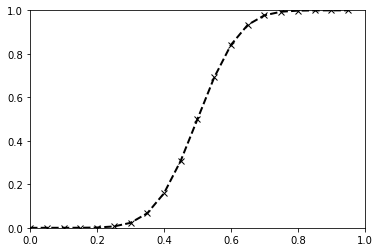

In [115]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()